In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading in the dataset and viewing the first few rows
df = pd.read_csv('cleaned_fraud.txt')
df.head()

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,347788,11.945973,7.775082,0.262675,1.0,1.0,1.0,1.0,0.0
1,845764,39.264472,24.749645,1.956956,1.0,0.0,0.0,0.0,0.0
2,230977,1.367472,3.131729,0.572104,0.0,1.0,0.0,1.0,0.0
3,962271,31.484941,0.161098,3.648510,1.0,0.0,0.0,1.0,0.0
4,154305,5.311520,3.537440,6.569696,1.0,1.0,0.0,1.0,1.0


In [3]:
# Removing unwanted columns 
df = df.drop(columns=['Unnamed: 0'])

# Checking Random Forest Assumptions

- Independent observations - yes
- Relevant features - yes 
- Sufficent amount of data - yes - at least 10 samples for every feature
- Balanced outcome class - will be addressed using SMOTE
- Minimal multicollinearity - no multicollinearity in the features used in the model
- Diversity amoung trees - will be sorted by bootstrapping

In [4]:
# Checking each observation is independent/unique
df.duplicated().sum()

0

In [5]:
# Checking all features are relevant
correlation_matrix = df.corr()
print(correlation_matrix['fraud'])

distance_from_home                0.174623
distance_from_last_transaction    0.086571
ratio_to_median_purchase_price    0.540148
repeat_retailer                  -0.008529
used_chip                        -0.040958
used_pin_number                  -0.091571
online_order                      0.168885
fraud                             1.000000
Name: fraud, dtype: float64


In [6]:
# Checking the shape of the df
df.shape

(9616, 8)

In [7]:
# Checking the counts of fraud in the outcome variable
df.fraud.value_counts()

fraud
0.0    8944
1.0     672
Name: count, dtype: int64

In [8]:
# Checking the positivity rate to see if the outcome classe is unbalanced
positivity_rate = 672/len(df)
print(positivity_rate)

0.06988352745424292


In [9]:
# Splitting the df into features and outcome variable
x = df.drop(columns=['fraud'])
y = df[['fraud']]

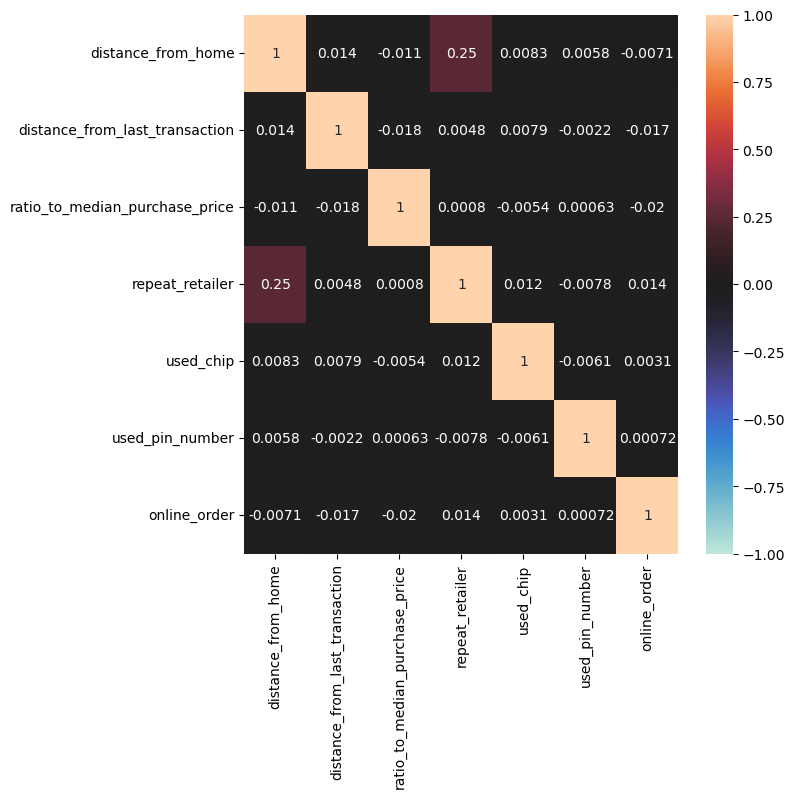

In [10]:
# Visualising the correlation between each feature
plt.figure(figsize=(7,7))
sns.heatmap(x.corr(), annot=True, vmin=-1, center=0, vmax=1)
plt.show()
# We can see that there are no features that share high correlation

# Train Test Split

In [11]:
# Splitting the features and outcome variable into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# SMOTE

In [12]:
# Checking the counts in the outcome variable for the training data
y_train.value_counts()

fraud
0.0      7156
1.0       536
Name: count, dtype: int64

In [13]:
# Creating SMOTE model
sm = SMOTE(random_state=1, sampling_strategy= 'minority')

# Fitting and resampling the training data
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

# Checking the counts of the outcome variable for the training data
y_train_res.value_counts()

fraud
0.0      7156
1.0      7156
Name: count, dtype: int64

# Random Forest Model

In [14]:
# Creating a random forest classifier
model = RandomForestClassifier(bootstrap=True, max_depth=3, random_state=1, n_jobs=-1)
model.fit(x_train_res, y_train_res)

RandomForestClassifier(max_depth=3, n_jobs=-1, random_state=1)

In [15]:
# Finding the scores for the training and testing data
print('Train score')
print(model.score(x_train_res, y_train_res))
print('Test score')
print(model.score(x_test, y_test))

Train score
0.9633174958077138
Test score
0.9818087318087318


In [16]:
# Getting the prediction on the training and test data
y_pred_train = model.predict(x_train_res)
y_pred_test = model.predict(x_test)

In [17]:
# Getting the accuracy score of the model on the testing data
accuracy = accuracy_score(y_test, y_pred_test)
print('Accuracy score is ' + str(accuracy))

# Getting the precision score of the model on the testing data
precision = precision_score(y_test, y_pred_test)
print('Precision score is ' + str(precision))

# Getting the recall score of the model on the testing data
recall_2 = recall_score(y_test, y_pred_test)
print('Recall score is ' + str(recall_2))

# Getting the f1 score of the model on the testing data
f1 = f1_score(y_test, y_pred_test)
print('F1 score is ' + str(f1))

Accuracy score is 0.9818087318087318
Precision score is 0.806060606060606
Recall score is 0.9779411764705882
F1 score is 0.8837209302325582


In [18]:
# Creating a confusion matrix to show the TN, FP, FN , TP
test_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_test), index=['Not Fraud', 'Fraud'], 
                                     columns=['Predicted Not Fraud', 'Predicted Fraud'])

test_confusion_matrix

,Predicted Not Fraud,Predicted Fraud
Not Fraud,1756,32
Fraud,3,133


In [19]:
# Checking the feature importance
importances = model.feature_importances_

for i, importance in enumerate(importances):
    print(f"Feature {x_train.columns[i]}: {importance}")

Feature distance_from_home: 0.10872419295797318
Feature distance_from_last_transaction: 0.02501980285881522
Feature ratio_to_median_purchase_price: 0.5205558795151242
Feature repeat_retailer: 0.005392755466594128
Feature used_chip: 0.0617629174722136
Feature used_pin_number: 0.05653372049297559
Feature online_order: 0.22201073123630405


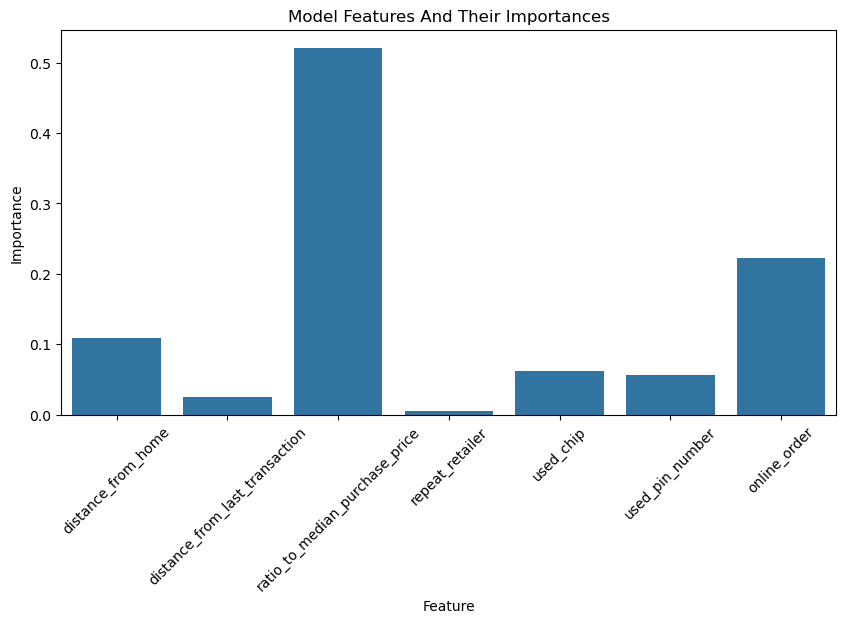

In [20]:
# Visualising the features and their importance
plt.figure(figsize=(10,5))
sns.barplot(x=x_train.columns, y=importances)
plt.title('Model Features And Their Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

# Hyperparameter Tuning

In [21]:
# Creating a dictionary of all the hyperparameters to tune
param_grid = {'max_features':['auto', 'sqrt'], 'max_depth':[3,5,7], 'n_estimators':[100, 200], 
              'min_samples_split':[1,2,5], 'min_samples_leaf':[1,2,5]}

# Creating a gridsearchcv model
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall', verbose=2, n_jobs=-1)

# Fitting the model to the training data
grid_search.fit(x_train_res, y_train_res)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=3, n_jobs=-1,
                                              random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [1, 2, 5],
                         'n_estimators': [100, 200]},
             scoring='recall', verbose=2)

In [22]:
# Checking the best parameter combination and cross validated score on the training data
print('Best params ' + str(grid_search.best_params_))
print('Best score ' + str(grid_search.best_score_))

Best params {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best score 0.9980434239446572


# Random Forest Model #2

In [23]:
# Creating a final classifier with the tuned parameters
model_2 = RandomForestClassifier(max_depth=grid_search.best_params_['max_depth'], 
                                 max_features=grid_search.best_params_['max_features'], 
                                 min_samples_leaf=grid_search.best_params_['min_samples_leaf'], 
                                 min_samples_split=grid_search.best_params_['min_samples_split'], 
                                 n_estimators=grid_search.best_params_['n_estimators'], 
                                 bootstrap=True, random_state=1, n_jobs=-1)

# Fitting the classifier to the training data
model_2.fit(x_train_res, y_train_res)

RandomForestClassifier(max_depth=7, min_samples_split=5, n_estimators=200,
                       n_jobs=-1, random_state=1)

# Evaluating Model #2

In [24]:
# Finding the scores for the training and testing data
print('Train score')
print(model_2.score(x_train_res, y_train_res))
print('Test score')
print(model_2.score(x_test, y_test))

Train score
1.0
Test score
0.998960498960499


In [25]:
# Getting the prediction on the training and test data
y_pred_train_2 = model_2.predict(x_train_res)
y_pred_test_2 = model_2.predict(x_test)

In [26]:
# Getting the accuracy score of the model on the testing data
accuracy_2 = accuracy_score(y_test, y_pred_test_2)
print('Accuracy score is ' + str(accuracy_2))

# Getting the precision score of the model on the testing data
precision_2 = precision_score(y_test, y_pred_test_2)
print('Precision score is ' + str(precision_2))

# Getting the recall score of the model on the testing data
recall_2 = recall_score(y_test, y_pred_test_2)
print('Recall score is ' + str(recall_2))

# Getting the f1 score of the model on the testing data
f1_2 = f1_score(y_test, y_pred_test_2)
print('F1 score is ' + str(f1_2))

Accuracy score is 0.998960498960499
Precision score is 1.0
Recall score is 0.9852941176470589
F1 score is 0.9925925925925926


In [27]:
# Creating a confusion matrix to show the TN, FP, FN , TP
test_confusion_matrix_2 = pd.DataFrame(confusion_matrix(y_test, y_pred_test_2), index=['Not Fraud', 'Fraud'], 
                                     columns=['Predicted Not Fraud', 'Predicted Fraud'])

test_confusion_matrix_2

,Predicted Not Fraud,Predicted Fraud
Not Fraud,1788,0
Fraud,2,134


In [28]:
# Checking the feature importances of model #2
importances_2 = model_2.feature_importances_

for i, importance in enumerate(importances_2):
    print(f"Feature {x_train.columns[i]}: {importance}")

Feature distance_from_home: 0.1571974371875038
Feature distance_from_last_transaction: 0.05960702289072968
Feature ratio_to_median_purchase_price: 0.5547974984697875
Feature repeat_retailer: 0.01019733588500382
Feature used_chip: 0.05757902938190944
Feature used_pin_number: 0.03020307721303464
Feature online_order: 0.13041859897203129


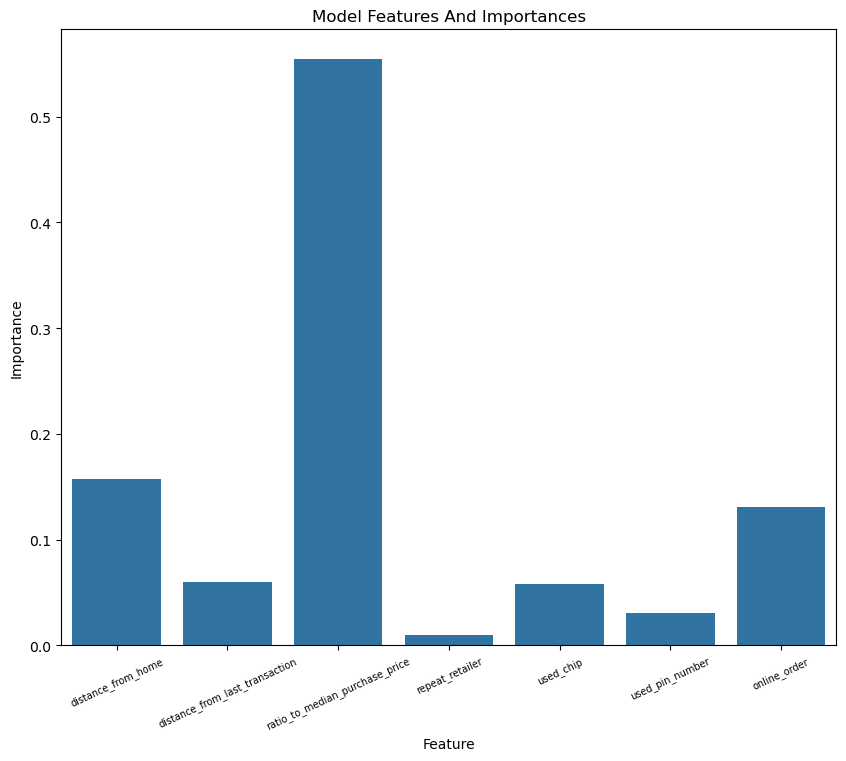

In [30]:
# Visualising the features and their importance for model 2
plt.figure(figsize=(10,8))
sns.barplot(x=x_train.columns, y=importances_2)
plt.title('Model Features And Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=25, size=7)
plt.savefig('rf_feature_importances.png')
plt.show()

# ROC Score & Thresholds

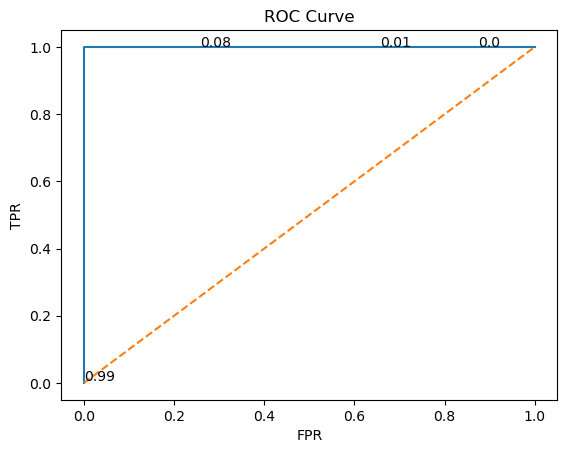

In [31]:
# Getting the probabilities of each outcome for the test set from model 2
y_pred_prob_test = model_2.predict_proba(x_test)

# Getting the true positive rate and false postive rate from the testing set
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob_test[:,1])

# Visualising the fpr and tpr 
plt.plot(fpr, tpr)
idx = list(range(len(threshold)))[1::100]
for i in idx:
    plt.text(fpr[i], tpr[i], threshold[i].round(2))
    
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(x_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, clf.predict_proba(x_test)[:,1])

clf_fpr, clf_tpr, clf_threshold = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
plt.plot(clf_fpr, clf_tpr, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.savefig('rf_roc_curve.png')
plt.show()

In [32]:
# Finding the roc auc score
roc_auc_score_ = roc_auc_score(y_test, y_pred_prob_test[:,1])
roc_auc_score_

0.9999917752335834

In [33]:
# Finding the best threshold youlden stat, highest tpr
j_scores = tpr - fpr

# Youlden's J statistic
youlden_threshold = threshold[np.argmax(j_scores)]
print(youlden_threshold)

0.36204794562330783


In [34]:
# Creating a confusion matrix when the threshold is youlden
y_pred_youlden = (y_pred_prob_test[:,1] > youlden_threshold)*1.0
cm_youlden = confusion_matrix(y_test, y_pred_youlden)
print(cm_youlden)

[[1787    1]
 [   1  135]]


In [35]:
# Getting the accuracy and recall score for the model at the optimal tpr threshold
accuracy_youlden = accuracy_score(y_test, y_pred_youlden)
print('Accuracy score is ' + str(accuracy_youlden))

recall_youlden = recall_score(y_test, y_pred_youlden)
print('Recall score is ' + str(recall_youlden))

Accuracy score is 0.998960498960499
Recall score is 0.9926470588235294


# Learning Curve

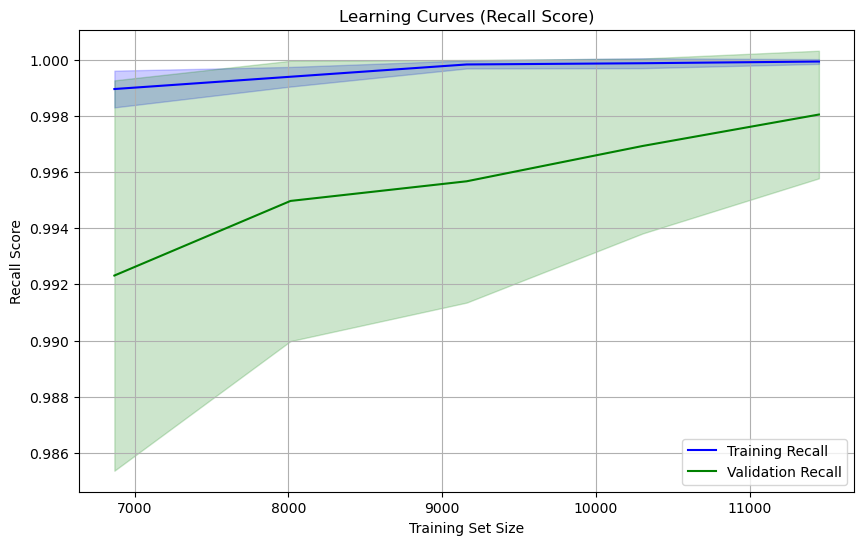

In [36]:
# Getting the learning curve data for the training and validation sets
train_sizes, train_scores, val_scores = learning_curve(model_2, x_train_res, y_train_res, cv=5, scoring='recall', 
                                                       train_sizes=np.linspace(0.1, 1.0, 10), random_state=1)

# Calculate the mean and std for the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Visualising the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Recall', color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation Recall', color='green')

# Filling below and above the mean by 1 std for the training and validation sets
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, color='green', alpha=0.2)

plt.title('Learning Curves (Recall Score)')
plt.xlabel('Training Set Size')
plt.ylabel('Recall Score')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('rf_learning_curve.png')
plt.show()

# Making Predictions

In [37]:
# Features
# 'distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
# 'used_pin_number', 'online_order'

transaction_1 = np.array([10, 10, 1, 1, 0, 1, 0])
transaction_2 = np.array([20, 20, 2, 0, 1, 0, 1])
transaction_3 = np.array([50, 50, 3, 1, 0, 1, 0])
transaction_4 = np.array([100, 100, 5, 0, 0, 0, 1])

# Adding all the predictions into the same variable
fraud_pred = np.stack((transaction_1, transaction_2, transaction_3, transaction_4))

In [38]:
# Using the model to get the predictions
print(model_2.predict(fraud_pred))
print(model_2.predict_proba(fraud_pred))
# Only transaction 4 was flagged as fraudulent

[0. 0. 0. 1.]
[[9.99656071e-01 3.43928754e-04]
 [8.73778110e-01 1.26221890e-01]
 [9.74891872e-01 2.51081280e-02]
 [5.56600932e-02 9.44339907e-01]]
